In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

In [2]:
def banana_log_prob(x, b=0.1):
    """
    Banana-shaped log density:
    x: [N, 2] array of particles
    b: banana parameter
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    term1 = -0.5 * (x1 / 2.0)**2
    term2 = -0.5 * ((x2 - b * x1**2 + 100 * b)**2 / 2.0)
    return term1 + term2

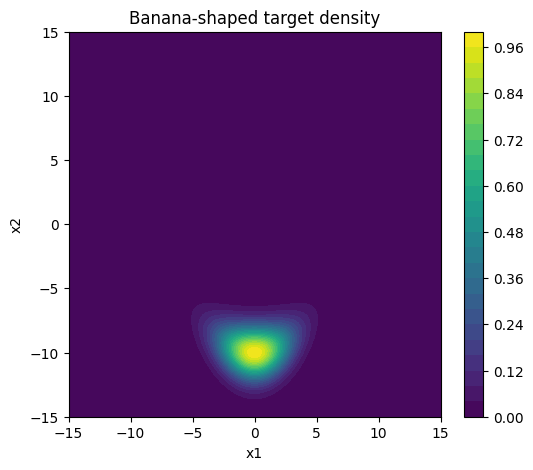

In [3]:
X, Y = np.meshgrid(np.linspace(-15, 15, 200), np.linspace(-15, 15, 200))
points = np.vstack([X.ravel(), Y.ravel()]).T
Z = np.exp(banana_log_prob(points).reshape(X.shape))

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, Z, levels=30, cmap="viridis")
plt.title("Banana-shaped target density")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


In [4]:
def rbf_kernel_matrix(X, h=-1):
    """
    Compute RBF kernel matrix and gradient terms.
    X: [N, D]
    Returns:
        K: [N, N]
        grad_K: [N, N, D]
    """
    N, D = X.shape
    pairwise_dists = np.sum((X[:, None, :] - X[None, :, :])**2, axis=2)

    if h <= 0:
        h = np.median(pairwise_dists)
        h = np.sqrt(0.5 * h / np.log(N + 1e-6))

    K = np.exp(-pairwise_dists / (2 * h**2))
    grad_K = -(X[:, None, :] - X[None, :, :]) * K[:, :, None] / (h**2)
    return K, grad_K


In [ ]:
def svgd_update(particles, log_prob_fn, stepsize=0.1):
    N, D = particles.shape
    particles = particles.copy()  
    eps = 1e-4
    score = np.zeros_like(particles)
    for i in range(D):
        shift = np.zeros(D)
        shift[i] = eps
        forward = log_prob_fn(particles + shift[None, :])
        backward = log_prob_fn(particles - shift[None, :])
        score[:, i] = (forward - backward) / (2 * eps)
    K, grad_K = rbf_kernel_matrix(particles)
    phi = (K @ score) / N + np.sum(grad_K, axis=1) / N
    particles += stepsize * phi
    return particles

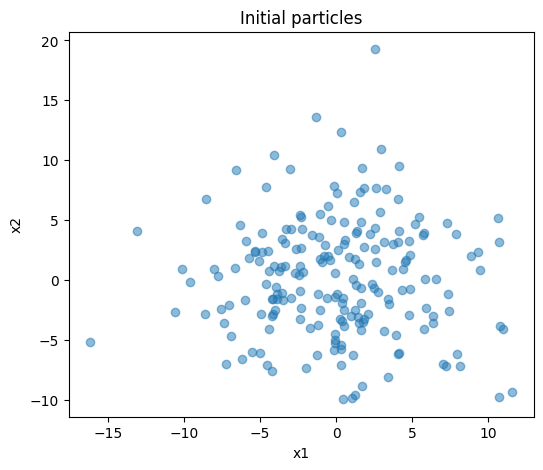

In [9]:
np.random.seed(42)
num_particles = 200
particles = np.random.randn(num_particles, 2) * 5.0

plt.figure(figsize=(6, 5))
plt.scatter(particles[:, 0], particles[:, 1], alpha=0.5)
plt.title("Initial particles")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [10]:
num_iterations = 500
stepsize = 0.1
trajectory = []

for it in range(num_iterations):
    particles = svgd_update(particles, banana_log_prob, stepsize)
    if it % 50 == 0 or it == num_iterations - 1:
        print(f"Iteration {it}")
        trajectory.append(particles.copy())


Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 499


ValueError: num must be an integer with 1 <= num <= 6, not 7

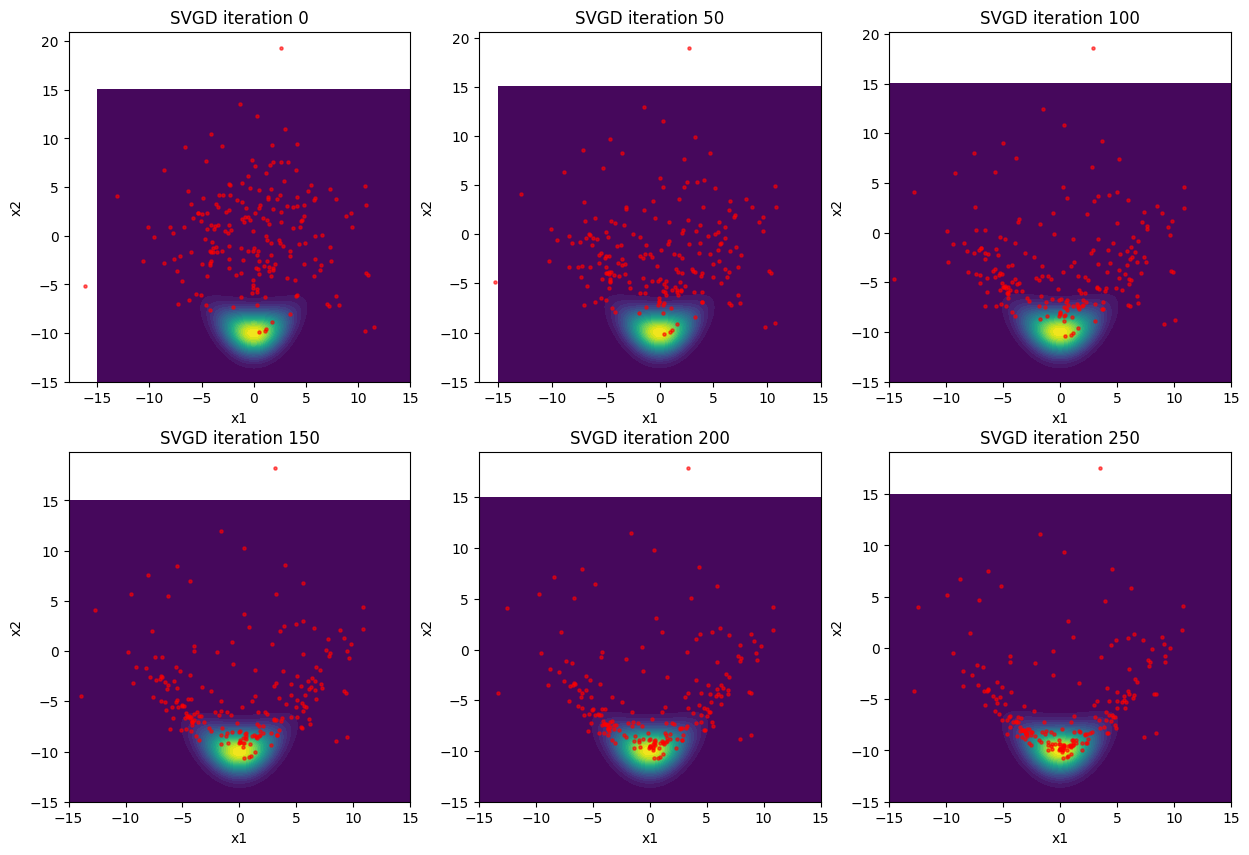

In [ ]:
plt.figure(figsize=(15, 10))
levels = 30

for i, particles_snapshot in enumerate(trajectory):
    plt.subplot(2, 3, i + 1)
    plt.contourf(X, Y, Z, levels=levels, cmap="viridis")
    plt.scatter(particles_snapshot[:, 0], particles_snapshot[:, 1], c='red', s=5, alpha=0.6)
    plt.title(f"SVGD iteration {i * 50}")
    plt.xlabel("x1")
    plt.ylabel("x2")

plt.tight_layout()
plt.show()


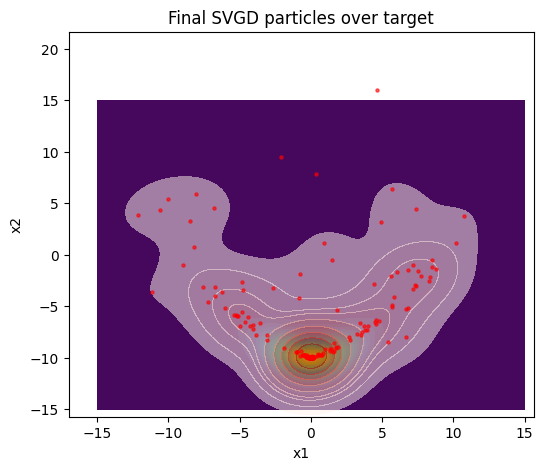

In [ ]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, Z, levels=30, cmap="viridis")
sns.kdeplot(x=particles[:, 0], y=particles[:, 1], fill=True, cmap="Reds", alpha=0.5)
plt.scatter(particles[:, 0], particles[:, 1], c='red', s=5, alpha=0.6)
plt.title("Final SVGD particles over target")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()